In [22]:
import json
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### Graph of communications modelling

In [44]:
# Read the citation_relations.json file and generate a graph
with open('./data/citation_relations.json', 'r') as f:
    cite_data = json.load(f)

In [71]:
# Check if there are duplicate entries in the graph
node_set = set()
for paper_id in cite_data.keys():
    node_set.add(paper_id)
print(f"Duplicates count = {len(cite_data.keys()) - len(node_set)}")

Duplicates count = 0


In [81]:
# Create a list of nodes in the format expected by networkX
node_list = []
index_dict = {} # Keep a dictionary to map paper_code to index
for index, paper_code in enumerate(cite_data.keys()):
    node_list.append({ 'id': index })
    index_dict[paper_code] = index

In [82]:
# Create a list of links in the format expected by networkX
link_list = []
for paper_id, paper_data in cite_data.items():
    for ref_paper_id in paper_data['references']:
        link_list.append({ 'source': index_dict[paper_id], 'target': index_dict[ref_paper_id] })

In [106]:
# Create an undirected graph from the node and link lists
graph_data = {
    'directed': False,
    'multigraph': False,
    'graph': {},
    'nodes': node_list,
    'links': link_list
}
G_comm = nx.node_link_graph(graph_data)

In [107]:
print(f"Number of nodes = {G_comm.number_of_nodes()}, number of edges = {G_comm.number_of_edges()}")

Number of nodes = 140799, number of edges = 658226


In [108]:
# Sample the graph to reduce its size 
from littleballoffur import RandomNodeSampler

total_nodes = G_comm.number_of_nodes()
sample_size = total_nodes // 10
sampler = RandomNodeSampler(number_of_nodes=sample_size, seed=42)
sampled_graph = sampler.sample(G_comm)

# Keep the largest connected component
largest_cc = max(nx.connected_components(sampled_graph), key=len)
sampled_graph = sampled_graph.subgraph(largest_cc).copy()

print(f"Sampled graph is connected = {nx.is_connected(sampled_graph)}")
print(f"Sampled graph is directed = {nx.is_directed(sampled_graph)}")
print(f"Number of nodes = {sampled_graph.number_of_nodes()}, number of edges = {sampled_graph.number_of_edges()}")

Sampled graph is connected = True
Sampled graph is directed = False
Number of nodes = 1291, number of edges = 1593


In [109]:
print(f"Average node degree = {np.mean(list(dict(sampled_graph.degree()).values()))}")
print(f"Median node degree = {np.median(list(dict(sampled_graph.degree()).values()))}")

Average node degree = 2.4678543764523626
Median node degree = 2.0


In [86]:
# Create a list of sampled nodes in the format expected by networkX
sampled_nodes = list(sampled_graph.nodes)
sampled_node_list = []
for node in sampled_nodes:
    sampled_node_list.append({ 'id': node, 'name': str(node) })

In [87]:
# Create a list of sampled links in the format expected by networkX
sampled_link_list = []
for paper_id, paper_data in cite_data.items():
    if index_dict[paper_id] not in sampled_graph.nodes:
        continue
    for ref_paper_id in paper_data['references']:
        if index_dict[ref_paper_id] in sampled_graph.nodes:
            sampled_link_list.append({ 'source': index_dict[paper_id], 'target': index_dict[ref_paper_id] })

In [88]:
# Create a graph from the sampled node and link lists
sampled_graph_data = {
    'directed': True,
    'multigraph': False,
    'graph': {},
    'nodes': sampled_node_list,
    'links': sampled_link_list
}
G_comm = nx.node_link_graph(sampled_graph_data)

### Create the network of similarities of communications

In [89]:
# Load the papers data
with open('./data/papers.SSN.jsonl', 'r') as f:
    papers = f.readlines()

In [90]:
papers[0]

'{"paper_id": "4650265", "title": "XGBoost: A Scalable Tree Boosting System", "abstract": ["tree boosting is a highly effective and widely used machine learning method .", "in this paper , we describe a scalable end - to - end tree boosting system called xgboost , which is used widely by data scientists to achieve state - of - the - art results on many machine learning challenges .", "we propose a novel sparsity - aware algorithm for sparse data and weighted quantile sketch for approximate tree learning .", "more importantly , we provide insights on cache access patterns , data compression and sharding to build a scalable tree boosting system .", "by combining these insights , xgboost scales beyond billions of examples using far fewer resources than existing systems ."], "section_names": ["introduction", "tree boosting in a nutshell", "regularized learning objective", "gradient tree boosting", "shrinkage and column subsampling", "basic exact greedy algorithm", "approximate algorithm", 

In [91]:
# Keep the abstracts of the papers that are in the sampled graph
abstracts = []
for paper in papers:
    paper_data = json.loads(paper)
    if index_dict[paper_data['paper_id']] not in sampled_nodes:
        continue
    abstracts.append((paper_data['paper_id'], " ".join(paper_data['abstract'])))

In [93]:
print(f"Number of abstracts = {len(abstracts)}")

Number of abstracts = 1291


In [96]:
# Save the graph to a CSV file
# nx.write_edgelist(G_sim, './data/similarity_graph.csv', delimiter=',')

In [97]:
def print_graph_info(G):
    print(f'Number of nodes: {G.number_of_nodes()}')
    print(f'Number of edges: {G.number_of_edges()}')
    print(f'Average node degree: {sum(dict(G.degree()).values())/G.number_of_nodes()}')
    print(f'Median node degree: {sorted(dict(G.degree()).values())[len(G)//2]}')

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def create_similarity_graph(index_dict, abstracts, m=1, n=1, p=0.75):

    # Calculate the similarity between the texts uning n-grams
    vectorizer = CountVectorizer(ngram_range=(m, n))
    X = vectorizer.fit_transform([abstract for _, abstract in abstracts])
    similarity_matrix = cosine_similarity(X, X)
    # Remove the diagonal values
    similarity_matrix[similarity_matrix > 0.99] = 0
    # print(similarity_matrix)
    
    # Keep the pairs that are statistically significant
    threshold = np.quantile(similarity_matrix, p)
    print(f'Threshold: {threshold}')

    # Create the list of edges in a networkx-friendly format
    G_sim = nx.Graph()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if similarity_matrix[i, j] > threshold:
                source_node = index_dict[abstracts[i][0]]
                target_node = index_dict[abstracts[j][0]]
                G_sim.add_edge(source_node, target_node)

    return G_sim

In [99]:
G_sim_1 = create_similarity_graph(index_dict, abstracts, m=1, n=1, p=0.9)
print_graph_info(G_sim_1)

Threshold: 0.5523060897787773
Number of nodes: 1087
Number of edges: 83333
Average node degree: 153.32658693652255
Median node degree: 90


In [100]:
G_sim_2 = create_similarity_graph(index_dict, abstracts, m=2, n=2, p=0.9)
print_graph_info(G_sim_2)

Threshold: 0.0590803351522041
Number of nodes: 1277
Number of edges: 83334
Average node degree: 130.5152701644479
Median node degree: 76


In [101]:
G_sim_3 = create_similarity_graph(index_dict, abstracts, m=3, n=3, p=0.9)
print_graph_info(G_sim_3)

Threshold: 0.01621834879088875
Number of nodes: 1273
Number of edges: 83330
Average node degree: 130.91908876669285
Median node degree: 81


In [102]:
G_sim_4 = create_similarity_graph(index_dict, abstracts, m=1, n=3, p=0.9)
print_graph_info(G_sim_4)

Threshold: 0.33301284565190525
Number of nodes: 1043
Number of edges: 83334
Average node degree: 159.7967401725791
Median node degree: 92


In [103]:
G_sim_5 = create_similarity_graph(index_dict, abstracts, m=2, n=3, p=0.9)
print_graph_info(G_sim_2)

Threshold: 0.037642820244861666
Number of nodes: 1277
Number of edges: 83334
Average node degree: 130.5152701644479
Median node degree: 76


### Load the network of similarities of communications

In [12]:
# G_sim = nx.read_edgelist('./data/similarity_graph.csv', delimiter=',')

### Permutation test

In [28]:
def keep_common_nodes(G1, G2):
    G1_trunc = G1.subgraph(G2.nodes)
    G2_trunc = G2.subgraph(G1.nodes)
    return G1_trunc, G2_trunc

In [29]:
def calculate_intersection_dict(G_comm, G_sim):
    # Iterate over all nodes and find the neighbors of each node in G_comm and G_sim
    intersection_dict = {}
    for node in G_comm.nodes:
        # Check if node is in both graphs
        if node not in G_sim.nodes:
            print(f"Node '{node}' is not in both graphs")
            continue
        network_comm_neighbors = set(G_comm.neighbors(node))
        network_sim_neighbors = set(G_sim.neighbors(node))
        intersection = network_comm_neighbors.intersection(network_sim_neighbors)
        union = network_comm_neighbors.union(network_sim_neighbors)
        jaccard_similarity = len(intersection) / len(union)
        intersection_dict[node] = {
            'intersection': intersection,
            'union': union,
            'jaccard_similarity': jaccard_similarity
        }
    return intersection_dict

In [30]:
def run_permutation_test(G_comm, G_sim):

    # Keep only the common nodes and calculate the intersection dictionary
    G_comm, G_sim = keep_common_nodes(G_comm, G_sim)
    common_nodes = list(G_comm.nodes)
    intersection_dict = calculate_intersection_dict(G_comm, G_sim)

    # Define population for permutation test
    comm_population = []
    for node in common_nodes:
        comm_neighbors = set(G_comm.neighbors(node))
        comm_population.append(list(comm_neighbors))

    sim_population = []
    for node in common_nodes:
        sim_neighbors = set(G_sim.neighbors(node))
        sim_population.append(list(sim_neighbors))

    # Perform the permutation test by examining random pairs of communication and similarity networks
    num_permutations = min(len(common_nodes), 20)
    p_values = []
    permuted_jaccard_values = []
    observed_jaccard_values = []

    for i in range(num_permutations):

        # Choose a network of communication
        comm_network = set(comm_population[i])
        # Retrieve the Jaccard similarity calculated before for the specific network
        observed_jaccard_values.append(intersection_dict[common_nodes[i]]['jaccard_similarity'])
        # Remove the respective similarity network for the similarity population
        new_sim_population = sim_population[:i] + sim_population[i+1:]

        # Try different combinations with networks of similarity
        for _ in range(num_permutations):

            # Permute the networks of similarity
            random.shuffle(new_sim_population)
        
            # Keep the first 100 networks of similarity due to computational constraints
            for j in range(0, min(len(new_sim_population), 100)):
                sim_network = set(new_sim_population[j])
                # Calculate the Jaccard similarity for the specific pair of networks
                intersection = comm_network.intersection(sim_network)
                union = comm_network.union(sim_network)
                jaccard_similarity = len(intersection) / len(union) if len(union) > 0 else 0
                permuted_jaccard_values.append(jaccard_similarity)
                # Check if the Jaccard similarity is greater than the observed one
                p_values.append(jaccard_similarity >= observed_jaccard_values[-1])

    # Calculate the p-value and the observed Jaccard similarity
    p_value = np.mean(p_values)
    observed_jaccard = np.mean(observed_jaccard_values)
    print(f"Observed Jaccard similarity = {observed_jaccard:.5f}")
    print(f"p-value = {p_value}")

    return p_value, observed_jaccard, permuted_jaccard_values

In [37]:
def visualise_permutation_test(permutation_jaccard_values, observed_jaccard):
    fig, ax = plt.subplots()
    ax.hist(permutation_jaccard_values, bins=30, edgecolor='black')
    ax.axvline(x=observed_jaccard, color='red', label='Observed value')
    ax.set_xlabel('Jaccard similarity')
    ax.set_ylabel('Frequency')
    ax.set_title('Permutation test for the Jaccard similarity')
    ax.semilogy()
    ax.legend()
    plt.show()

Observed Jaccard similarity = 0.01831
p-value = 0.6432


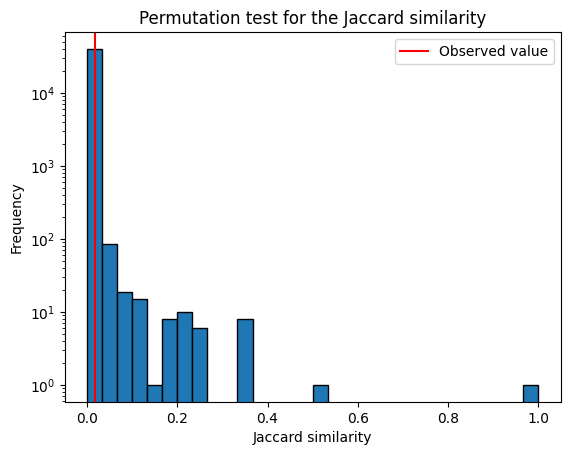

In [38]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_1)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.00752
p-value = 0.569225


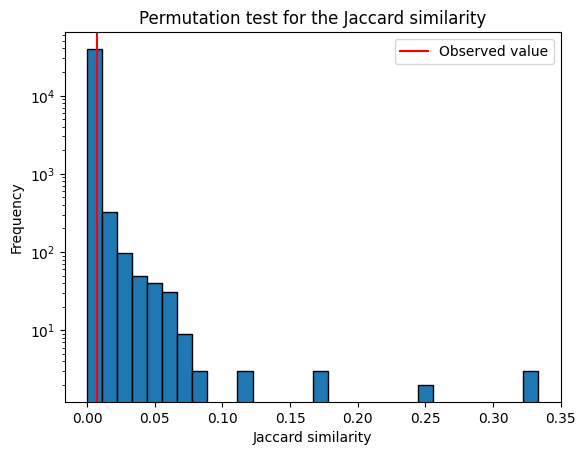

In [39]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_2)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.00168
p-value = 0.772225


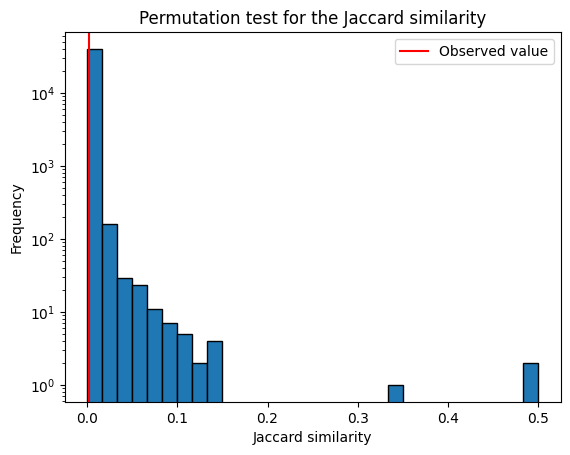

In [40]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_3)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.00958
p-value = 0.690375


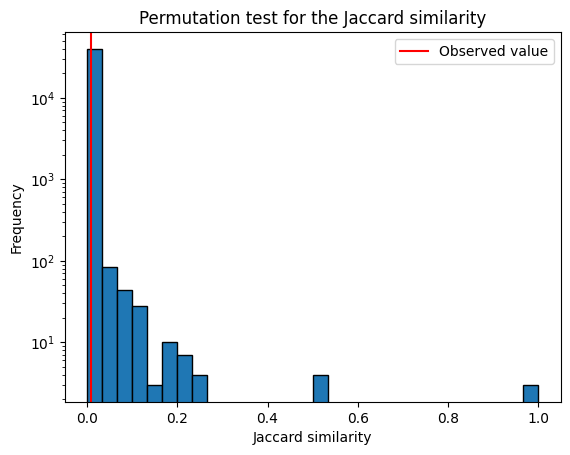

In [41]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_4)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)

Observed Jaccard similarity = 0.00639
p-value = 0.6182


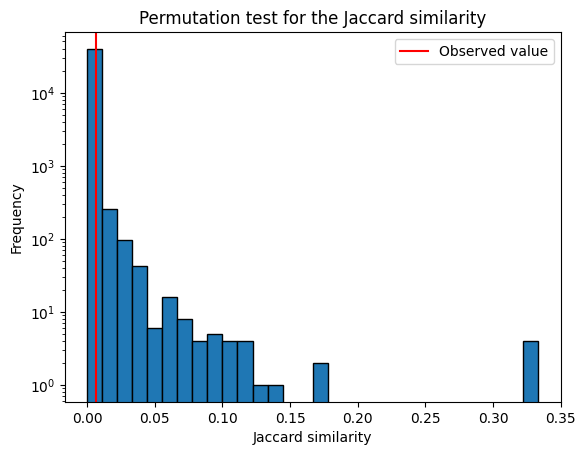

In [42]:
p_value, observed_jaccard, permutation_jaccard_values = run_permutation_test(G_comm, G_sim_5)
visualise_permutation_test(permutation_jaccard_values, observed_jaccard)